In [52]:
import json

with open("../raw/label_descriptions.json") as f:
    meta = json.load(f)
    
meta.keys()

dict_keys(['info', 'categories', 'attributes'])

In [53]:
df_ctg = pd.DataFrame(meta["categories"]).set_index("id")
df_ctg

,name,supercategory,level
id,,,
0,"shirt, blouse",upperbody,2
1,"top, t-shirt, sweatshirt",upperbody,2
2,sweater,upperbody,2
3,cardigan,upperbody,2
4,jacket,upperbody,2
5,vest,upperbody,2
6,pants,lowerbody,2
7,shorts,lowerbody,2
8,skirt,lowerbody,2


In [54]:
df_attr = pd.DataFrame(meta["attributes"]).set_index("id")
df_attr

,name,supercategory,level
id,,,
0,above-the-hip (length),length,1
1,hip (length),length,1
2,micro (length),length,1
3,mini (length),length,1
4,above-the-knee (length),length,1
...,...,...,...
87,high waist,waistline,1
88,normal waist,waistline,1
89,low waist,waistline,1


In [2]:
df = pd.read_csv("../raw/train.csv")
df

,ImageId,EncodedPixels,Height,Width,ClassId
0,00000663ed1ff0c4e0132b9b9ac53f6e.jpg,6068157 7 6073371 20 6078584 34 6083797 48 608...,5214,3676,6
1,00000663ed1ff0c4e0132b9b9ac53f6e.jpg,6323163 11 6328356 32 6333549 53 6338742 75 63...,5214,3676,0
2,00000663ed1ff0c4e0132b9b9ac53f6e.jpg,8521389 10 8526585 30 8531789 42 8537002 46 85...,5214,3676,28
3,00000663ed1ff0c4e0132b9b9ac53f6e.jpg,12903854 2 12909064 7 12914275 10 12919485 15 ...,5214,3676,31
4,00000663ed1ff0c4e0132b9b9ac53f6e.jpg,10837337 5 10842542 14 10847746 24 10852951 33...,5214,3676,32
...,...,...,...,...,...
331208,fffe20b555b98c3c1f26c8dfff275cbc.jpg,2712731 8 2715725 23 2718719 39 2721713 55 272...,3000,2001,28
331209,ffffbf7014a9e408bfbb81a75bc70638.jpg,71179 1 71678 3 72178 4 72678 4 73178 5 73679 ...,500,375,33
331210,ffffbf7014a9e408bfbb81a75bc70638.jpg,116648 5 117148 16 117648 22 118148 26 118647 ...,500,375,31
331211,ffffbf7014a9e408bfbb81a75bc70638.jpg,67711 1 68210 1 68709 2 69204 2 69208 3 69705 ...,500,375,31


In [50]:
# c.f., https://www.kaggle.com/c/imaterialist-fashion-2019-FGVC6/overview/evaluation
# ClassId: {category_id}_{attribute_id1}_{attribute_id2}_...

df_multi = df[df["ClassId"].apply(len) >= 3]
df_multi["ClassId"]

42           10_3_20_34_56_69_91
44         3_1_10_20_41_60_61_91
48        10_5_19_33_59_61_66_88
92            4_0_20_41_60_72_88
97               6_8_20_39_60_70
                   ...          
331136           8_3_20_33_60_61
331137     3_6_11_19_40_60_61_88
331163           1_0_20_41_49_61
331165     6_8_15_20_40_60_61_87
331166     9_3_10_20_41_60_61_91
Name: ClassId, Length: 11499, dtype: object

In [4]:
# c.f., https://github.com/amirassov/kaggle-imaterialist/blob/master/src/rle.py
from itertools import groupby
from pycocotools import mask as mutils
import numpy as np


def kaggle_rle_encode(mask):
    pixels = mask.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    rle = np.where(pixels[1:] != pixels[:-1])[0] + 1
    rle[1::2] -= rle[::2]
    return rle.tolist()


def kaggle_rle_decode(rle: np.ndarray, h, w):
    starts, lengths = map(np.asarray, (rle[::2], rle[1::2]))
    starts -= 1
    ends = starts + lengths
    img = np.zeros(h * w, dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape((w, h)).T


def coco_rle_encode(mask):
    rle = {'counts': [], 'size': list(mask.shape)}
    counts = rle.get('counts')
    for i, (value, elements) in enumerate(groupby(mask.ravel(order='F'))):
        if i == 0 and value == 1:
            counts.append(0)
        counts.append(len(list(elements)))
    return rle


def coco_rle_decode(rle, h, w):
    return mutils.decode(mutils.frPyObjects(rle, h, w))


def kaggle2coco(kaggle_rle, h, w):
    if not len(kaggle_rle):
        return {'counts': [h * w], 'size': [h, w]}
    roll2 = np.roll(kaggle_rle, 2)
    roll2[:2] = 1

    roll1 = np.roll(kaggle_rle, 1)
    roll1[:1] = 0

    if h * w != kaggle_rle[-1] + kaggle_rle[-2] - 1:
        shift = 1
        end_value = h * w - kaggle_rle[-1] - kaggle_rle[-2] + 1
    else:
        shift = 0
        end_value = 0
    coco_rle = np.full(len(kaggle_rle) + shift, end_value)
    coco_rle[:len(coco_rle) - shift] = kaggle_rle.copy()
    coco_rle[:len(coco_rle) - shift:2] = (kaggle_rle - roll1 - roll2)[::2].copy()
    return {'counts': coco_rle.tolist(), 'size': [h, w]}


# def main():
#     for _ in range(100):
#         h = np.random.randint(1, 1000)
#         w = np.random.randint(1, 1000)
#         mask = np.random.randint(0, 2, h * w).reshape(h, w)

#         kaggle_rle = kaggle_rle_encode(mask)
#         coco_rle = coco_rle_encode(mask)
#         assert coco_rle == kaggle2coco(kaggle_rle, h, w)
#         assert np.all(mask == kaggle_rle_decode(kaggle_rle, h, w))
#         assert np.all(mask == coco_rle_decode(coco_rle, h, w))


# if __name__ == '__main__':
#     main()

In [5]:
row = df_multi.iloc[0]
row

ImageId                       000aac3870ea7c59ca0333ffa5327323.jpg
EncodedPixels    8971124 17 8975101 49 8979077 82 8983053 116 8...
Height                                                        4000
Width                                                         6000
ClassId                                        10_3_20_34_56_69_91
Name: 42, dtype: object

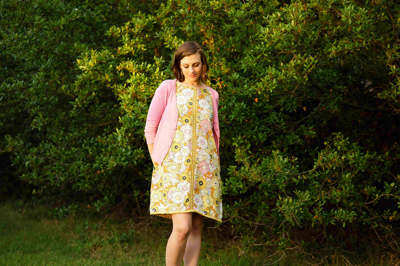

In [6]:
from PIL import Image

pil_img = Image.open(Path("../raw/train") / row["ImageId"]).convert("RGB")
pil_img.resize(
    (int(pil_img.size[0] / 15),
    int(pil_img.size[1] / 15))
)

In [7]:
mask = kaggle_rle_decode([int(x) for x in row["EncodedPixels"].split()], row["Height"], row["Width"])

np.unique(mask)
mask.shape

array([0, 1], dtype=uint8)

(4000, 6000)

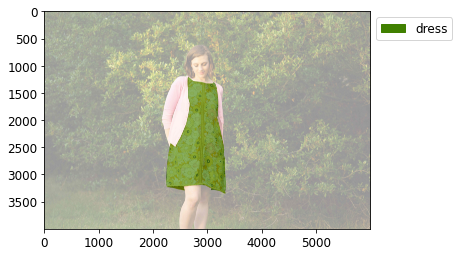

In [48]:
from segmentation.visualizations import vis_semantic_segmentation

category_id = int(row["ClassId"].split("_")[0])
label = (category_id * mask).astype(np.int32)
label[label == 0] = -1

ax, legend_handles = vis_semantic_segmentation(
    # (ch=3, height, width)
    np.array(pil_img).transpose(2,0,1),
    label,
    label_names=df_ctg["name"].tolist(),
    ignore_label_color=[255,255,255],
    all_label_names_in_legend=True,
    alpha=0.6,
)
_ = ax.legend(handles=legend_handles, bbox_to_anchor=(1, 1), loc=2)

In [49]:
df_attr.iloc[[int(x) for x in row["ClassId"].split("_")[1:]]]

,name,supercategory,level
id,,,
3,mini (length),length,1
20,symmetrical,silhouette,1
34,a-line,silhouette,1
56,cutout,"textile finishing, manufacturing techniques",1
69,floral,textile pattern,1
91,no waistline,waistline,1
